# Store item demand forecasting
In this project, I will build a machine learning model to forecast 3 months of 50 items sales in 10 different stores of a company. It involves supervised learning, using a labeled training set for time series forecasting.

I will use the following pipeline, based on CRISP-DM framework:

1. Business understanding
2. Data understanding
3. Data preparation
4. Modelling
5. Evaluation
6. Deployment

In this notebook, I will be covering steps 3 to 6 of the pipeline above. The main objective here is to build a model capable of accurately forecasting sales for 50 items across 10 stores over a three-month period, interpreting its outcomes and determining financial results. Furthermore, I will approach these steps in detail below, explaining why I am making each decision.

### Importing the libraries

In [43]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import clone
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor
from lightgbm import plot_importance
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import optuna
import statsmodels.api as sm
import os
import pickle

# Utils.
from src.modelling_utils import *
from src.artifacts_utils import save_object

# Fixing bayesian search error.
np.int = int

# Warnings filtering.
import warnings
warnings.filterwarnings('ignore')

# Plot grid styles.
sns.set_theme(style='whitegrid')

### Reading the dataset

In [3]:
data_path = '../input/train.csv'
df_raw = pd.read_csv(data_path)

In [4]:
df_raw.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


I will convert the date column to the correct data type (datetime) and set it as the dataset index in order to turn the modelling step easier. In a forecasting task, the date column is very important. From the dates, other time series features will be created and we will be able to visualize the sales trends, seasonal patterns and characteristics over time. 

In [5]:
df_raw['date'] = pd.to_datetime(df_raw['date'])
df_raw.set_index('date', inplace=True)
df_raw.sort_values(by=['date', 'store', 'item'], inplace=True)
df_raw.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-01,1,2,33
2013-01-01,1,3,15
2013-01-01,1,4,10
2013-01-01,1,5,11


In [15]:
print(f'The data goes from {df_raw.index.min()} to {df_raw.index.max()}.')

The data goes from 2013-01-01 00:00:00 to 2017-12-31 00:00:00.


### Time series train-test-split
- First of all, I will split the data into train and test sets.
- Test set is supposed to be data the model has never seen before. Thus, I will do all the modelling using the training set. Test set will be used just to evaluate my final model, simulating a real production environment.
- Once the objective is to predict 3 months of item demand, I will separate 3 months of data for the test. An important observation here is that I will divide the data chronologically, using earlier data for training and later data for testing, ensuring the model predicts future events. Randomly splitting the data would lead to data leakage. 

In [6]:
CUTOFF_DATE = '2017-09-30'
train, test = time_series_split(df_raw, CUTOFF_DATE)
print(f'Train shape: {train.shape}. Train data goes from {train.index.min()} to {train.index.max()}.')
print(f'Test shape: {test.shape}. Train data goes from {test.index.min()} to {test.index.max()}.')

Train shape: (866500, 3). Train data goes from 2013-01-01 00:00:00 to 2017-09-29 00:00:00.
Test shape: (46500, 3). Train data goes from 2017-09-30 00:00:00 to 2017-12-31 00:00:00.


Let's visualize the time series train-test-split.

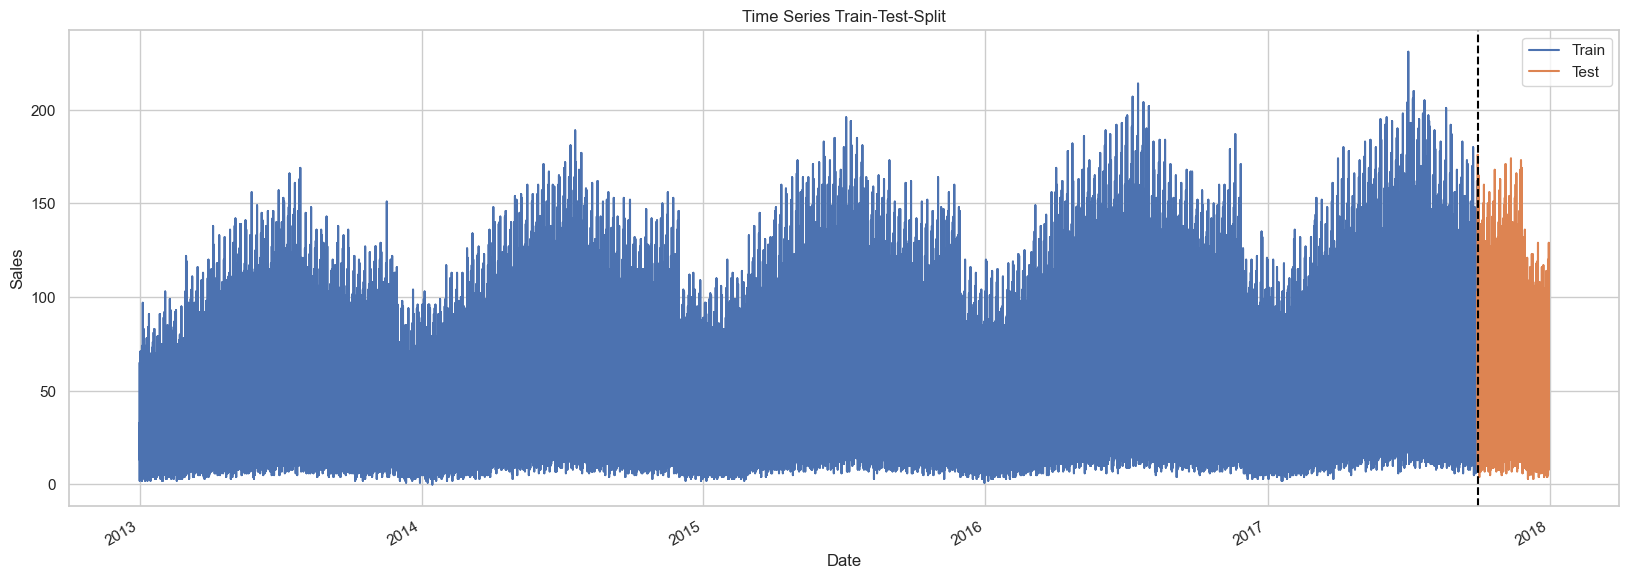

In [7]:
plot_time_series_split(train, test, CUTOFF_DATE)

### Time series decomposition
- I will break the time series into components in order to analyze underlying patterns, trends and seasonal variations which will help in building useful features for the model.
- Trend Component: Underlying long-term progression or direction of the time series. Shows wheter the data is increasing, decreasing or remaining relatively constant over time.
- Seasonal Component: Regular, periodic fluctuations or patterns that occurs at specific intervals within the time series (annually, quarterly, monthly, and so on).
- Cyclical Component: Fluctuations in the time series that are not of a fixed period. Typically associated with business/economic cycles.
- Residual Component: Random fluctuations or irregularities that cannot be attributed to the trend, seasonal or cyclical patterns. Unexplained variability in the time series.
- A time series is stationary if its statistical characteristics, such as mean, variance and covariance don't change over time.
- I will use the additive model, in which we sum up these components.

<Figure size 640x480 with 0 Axes>

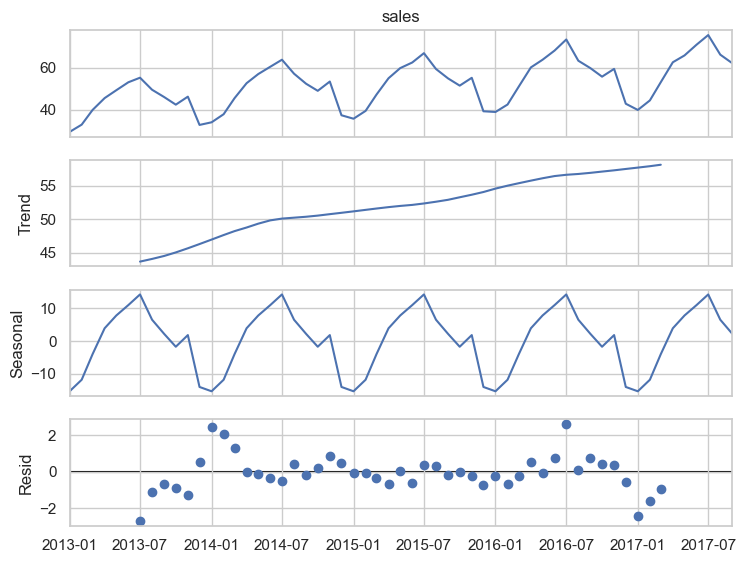

In [90]:
monthly_avg_sales = train['sales'].resample('MS').mean()
ts_decomposition = sm.tsa.seasonal_decompose(monthly_avg_sales, model='additive')

fig = plt.figure()  
fig = ts_decomposition.plot()  
fig.set_size_inches(8, 6)

1. The time series is not stationary.
2. There is an increasing trend on sales over time.
3. There is seasonality. The sales are higher around july.
4. The residuals are randomly distributed around zero. This randomness suggests that the model is capturing most of the systematic patterns in the data.

### Time series cross validation
- Time series data is a sequence of data points indexed in time order, typically at uniform intervals.
- We cannot choose random samples and assign them to either training or validation sets as it makes no sense in using the values from the future data to predict values of the past data.
- We split the data into training and validation set according to time - "forward chaining" method or rolling/extending cross-validation
- We start with a subset of data as the training set. Based on that set we predict later data points and then check the score. The Predicted samples are then included as part of the next training dataset and subsequent samples are forecasted.
- I will use sklearn TimeSeriesSplit to apply time series expanding cross validation. This technique will allow us to assess the model's ability to generalize to unseen data points in the future, comparing different models trained on distinct data preparation approaches.

Let's see wheter the time series split is being correctly made. Considering that we want to forecast 3 months of future sales for 50 items at 10 different stores and the sales are recorded daily, I will define a test size of 1x93x50x10. Moreover, I will define a one week gap between train and validation sets in order to avoid overfitting. A 7 days gap will be a period of 1x7x50x10.

------------------------------
Fold 0
Train: 0 to 630499
Validation: 634000 to 680499
------------------------------
Fold 1
Train: 0 to 676999
Validation: 680500 to 726999
------------------------------
Fold 2
Train: 0 to 723499
Validation: 727000 to 773499
------------------------------
Fold 3
Train: 0 to 769999
Validation: 773500 to 819999
------------------------------
Fold 4
Train: 0 to 816499
Validation: 820000 to 866499


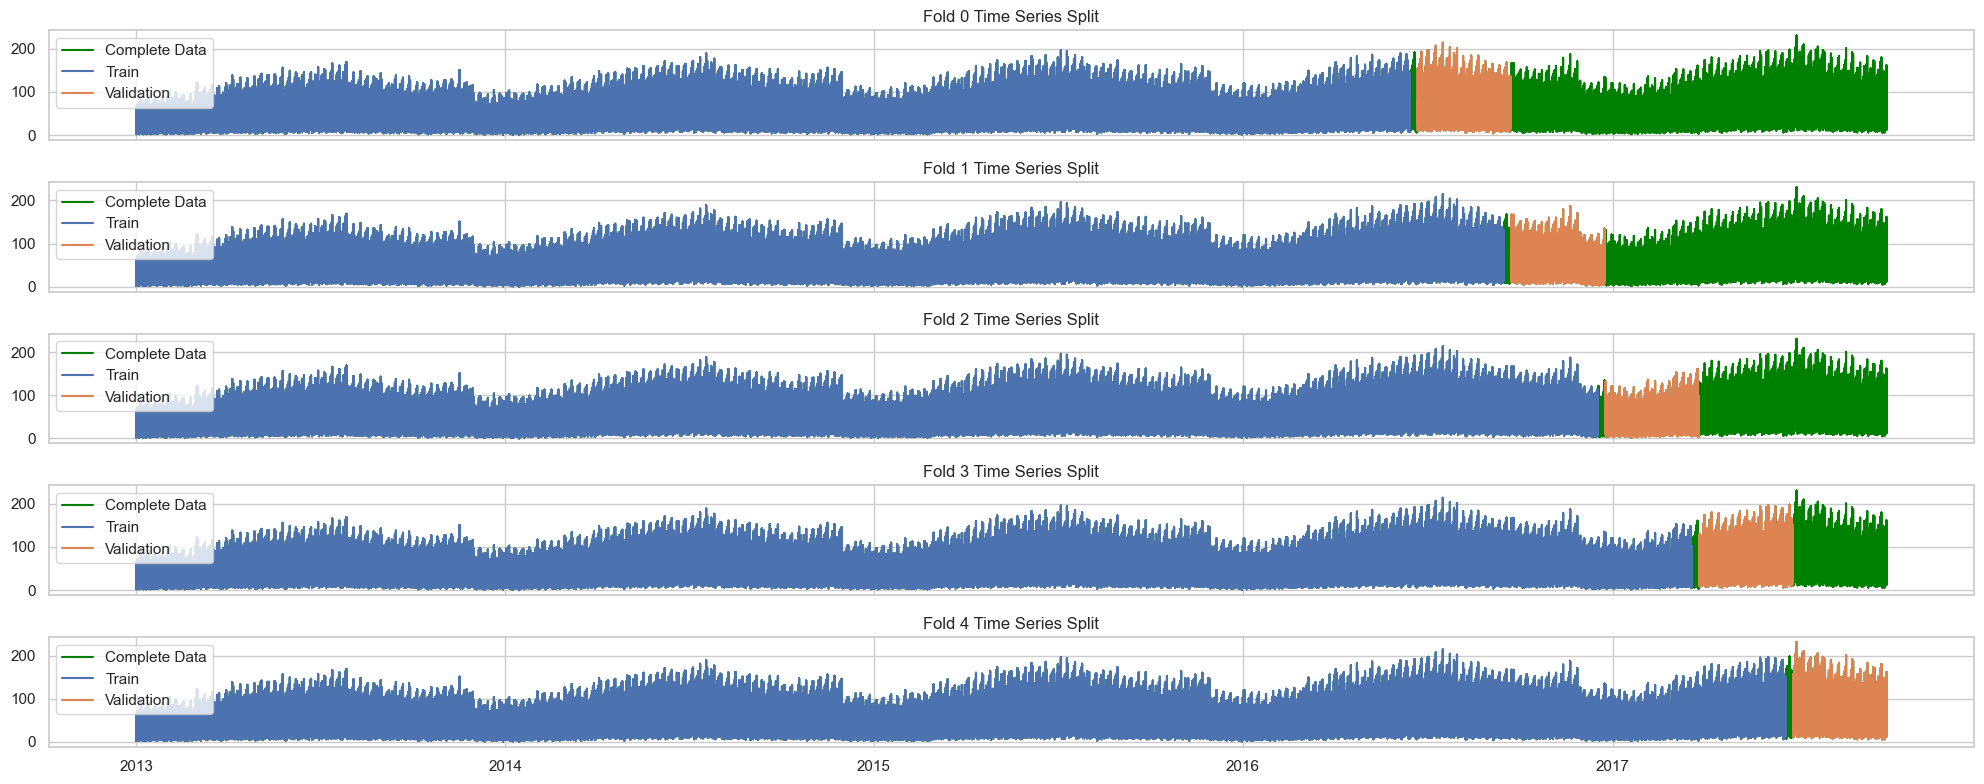

In [8]:
TEST_SIZE, GAP, TARGET = 1*93*50*10, 1*7*50*10, 'sales'
time_series_cv_report(train,  target=TARGET, test_size=TEST_SIZE, gap=GAP, n_splits=5)

Clearly, the time series split is indeed correct! It is possible to see that training data covers the 50 items sales for stores 1 to 10 across a time period while validation set starts a week after this time period, covering the 50 items sales for stores 1 to 10 too.

# 4. Data preparation
- In this step, I will do all the data preparation, like feature engineering, train-test split and data preprocessing. 
- I will be turning back to this phase after modelling in order to test different approaches (from simpler to more complex ones) until the best performance is achieved in a crisp-dm data preparation / modelling cycle. Thus, I will enumerate the distinct data preparations and modelling approaches I will test. This enumeration will represent the experiments sequence. For example, a model trained with a data preparation made in 4.2 will be in section 5.2.
- I will use time series cross validation to evaluate the model trained on different approaches of data preparation and modelling. By doing this, I will obtain a more reliable performance indicator. Moreover, this will enable me to use the test set only to evaluate the final model, simulating production data. 
- I intend to use LightGBM for the sales forecasting because I am focusing on the predictive power. LightGBM offers fast training and high predictive power by using the gradient boosting framework. 
- Tree-based models like LightGBM don't require feature scaling. Thus, I will not scale the data.
- Time series features like dayofweek and weeokfyear already present ordinal relationships, allowing the ensembles to capture seasonality and so on. Thus, it may not be an advantage encoding them. One-hot encoding, for example, would damage trees performance due to sparse representation and dimensionality increase. 
- Although they are in numeric data type, features like store and item present categorical behaviour and could be encoded. Initially, I don't intend to perform any transformation to these features. However, as I said, I will test different approaches.
- LightGBM already deals with missing values, so, when creating features like lags or rolling statistics, I will not treat them.
- The outliers were investigated in the EDA step. Once they don't represent iconsistent information, I will not treat them.
- For time series forecasting, a bunch of features can be created, including date-related features, lag features, rolling statistics, holiday indicators, time-based aggregations and so on. I will test them below.
- Considering that sales variable is significantly right-skewed, a log-transformation can be applied to normalize it, turning it more symmetric. I will test it below.

### 4.1.0 Baseline
Below I will start with a baseline data preparation and modelling. Then, I will try to enhance this baseline model performance.

### 4.1.1 Basic feature engineering
Initially, let's create basic date-related time series features. 

In [9]:
def create_date_features(data):
    
    df = data.copy()
    
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype(np.float64)
    df['is_wknd'] = df.index.weekday // 4
    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)

    return df

In [10]:
df_date = create_date_features(df_raw)
df_date.head()

,store,item,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_wknd,is_month_start,is_month_end
date,,,,,,,,,,,,,
2013-01-01,1,1,13,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,2,33,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,3,15,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,4,10,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,5,11,1,1,1,2013,1,1,1.0,0,1,0


### 4.2.0 Log Transformation
Considering that sales variable is significantly right-skewed (I found this on EDA step), I will apply a log transformation to it in order to turn it more symmetric. By doing this, the model will better capture the patterns behind the data. An important observation here is that there are records with zero sales. Thus, I will add a constant (1) to the log transformation.

In [12]:
df_log = df_raw.copy()
df_log['sales'] = np.log1p(df_log['sales'])
df_log = create_date_features(df_log)
df_log.head()

,store,item,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_wknd,is_month_start,is_month_end
date,,,,,,,,,,,,,
2013-01-01,1,1,2.639057,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,2,3.526361,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,3,2.772589,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,4,2.397895,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,5,2.484907,1,1,1,2013,1,1,1.0,0,1,0


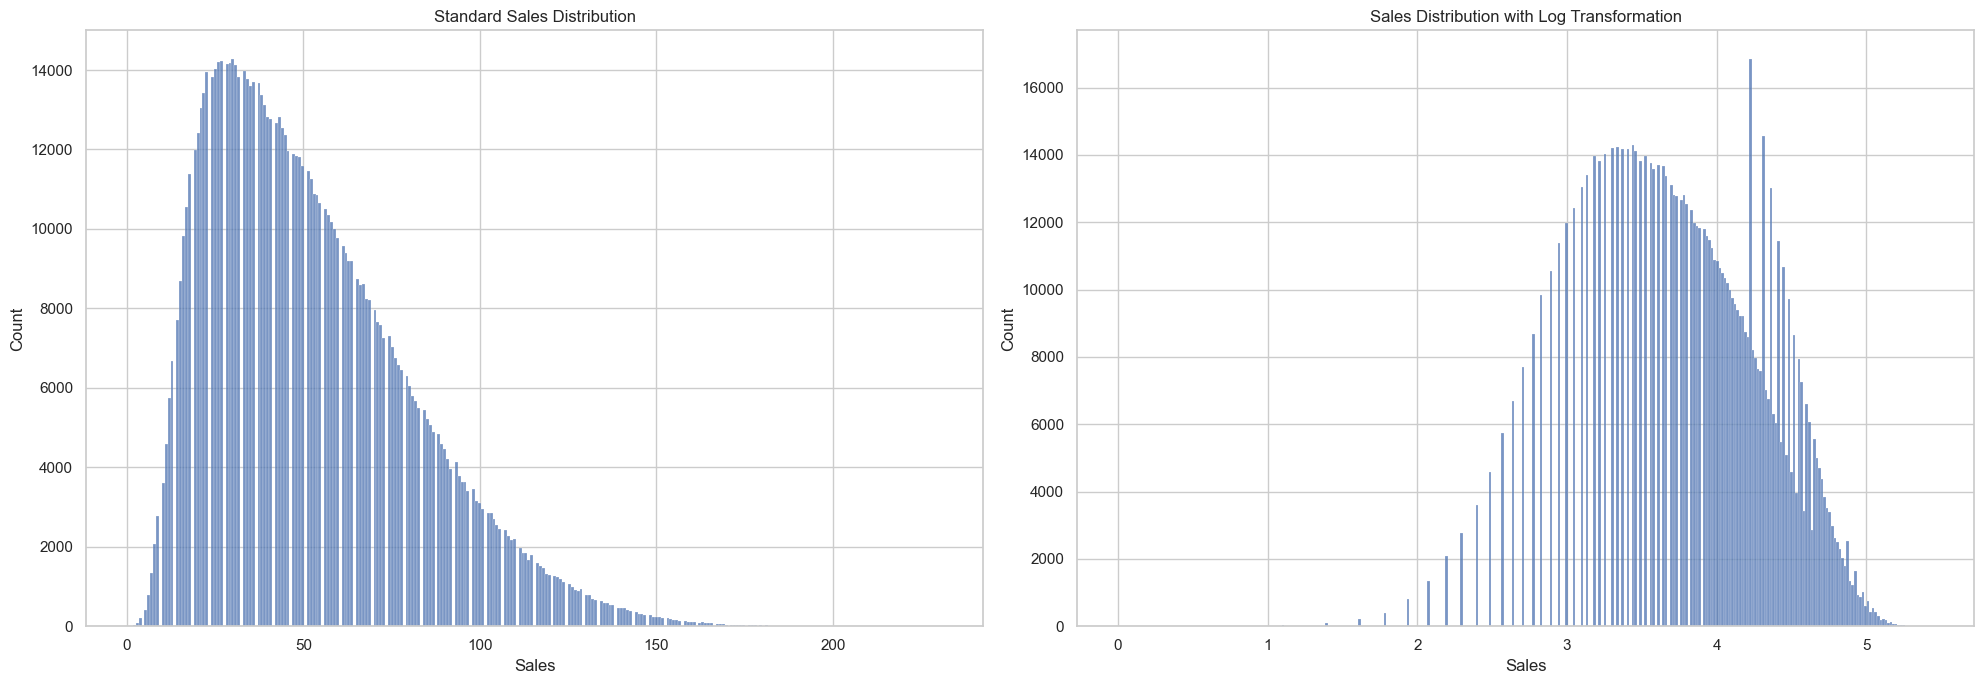

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax0 = sns.histplot(data=df_raw, x='sales', ax=ax[0])
ax0.set_title('Standard Sales Distribution')
ax0.set_xlabel('Sales')
ax0.set_ylabel('Count')

ax1 = sns.histplot(data=df_log, x='sales', ax=ax[1])
ax1.set_title('Sales Distribution with Log Transformation')
ax1.set_xlabel('Sales')
ax1.set_ylabel('Count')

plt.tight_layout()
plt.show()

By applying log transformation to sales variable, its distribution becomes more symmetric, allowing the model to better capture the patterns behind the data.

### 4.2.1 Lag features
- Lag features are the past observations of a time series variable used as input features for predicting future values.
- Incorporating lag features enables the model to capture temporal dependencies and patterns within the time series data.
- The lag value we choose will depend on the correlation of individual values with its past values.
- A way to determining the lag at which the correlation is significant is using the ACF (autocorrelation function) and PACF (partial autocorrelation function) plots. 
- ACF: The ACF plot is a measure of the correlation between the time series and the lagged version of itself
- PACF: The PACF plot is a measure of the correlation between the time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons
- I will add sales lag features from 3 months, 3 months and some weeks, six months, a year, a year and a half and 2 years in the past. I will do this because we are trying to forecast 3 months of sales and the data presents weekly seasonality (sales are higher on sunday), monthly seasonality (sales are higher on july) and an yearly increase trend.

First, it is necessary to sort the values by store, item and date. By doing this, we can get the correct lags - a lag for an item sales at a store will be the past sales values for the same item and store.

In [13]:
df_log.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)
df_log.head()

,store,item,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_wknd,is_month_start,is_month_end
date,,,,,,,,,,,,,
2013-01-01,1,1,2.639057,1,1,1,2013,1,1,1.0,0,1,0
2013-01-02,1,1,2.484907,2,1,1,2013,2,2,1.0,0,0,0
2013-01-03,1,1,2.708050,3,1,1,2013,3,3,1.0,0,0,0
2013-01-04,1,1,2.639057,4,1,1,2013,4,4,1.0,1,0,0
2013-01-05,1,1,2.397895,5,1,1,2013,5,5,1.0,1,0,0


Defining a function to create the lags.

In [14]:
def create_lag_features(data, lags):
    df = data.copy()
    for lag in lags:
        df['sales_lag_' + str(lag)] = df.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(lag))
    
    return df

Creating the lag features.

In [15]:
lags = [91, 98, 105, 112, 119, 126, 182, 364, 546, 728]
df_log = create_lag_features(df_log, lags=lags)
# Turning back to ordered date values, necessary for time series cross validation.
df_log.sort_values(by=['date', 'store', 'item'], inplace=True)
df_log

,store,item,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,2.639057,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,2,3.526361,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,3,2.772589,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,4,2.397895,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,5,2.484907,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31,10,46,4.262680,6,4,12,2017,365,31,52.0,...,4.219508,4.532599,4.418841,4.634729,4.543295,4.574711,4.595120,4.276666,4.663439,3.951244
2017-12-31,10,47,3.135494,6,4,12,2017,365,31,52.0,...,3.526361,3.496508,3.433987,3.496508,3.401197,3.784190,3.688879,3.295837,3.761200,2.995732
2017-12-31,10,48,4.110874,6,4,12,2017,365,31,52.0,...,4.330733,4.454347,4.394449,4.605170,4.369448,4.564348,4.682131,3.988984,4.624973,3.970292


The lags were succesfully created! The initial values in the data will contain NaN's, once there is not 91 days or more past data available. Since LightGBM deals with missing values, I will not impute or treat them. Let's check autocorrelation (ACF) and partial autocorrelation (PACF) functions in order to assess wheter this lags are useful for the model.

In [20]:
acf = plot_acf(df_log['sales'], lags=lags)
fig = plt.figure()  
fig.set_size_inches(8, 6)

In [26]:
# pacf = plot_pacf(df_log['sales'], lags=lags)
# fig = plt.figure()  
# fig.set_size_inches(8, 6)

It is possible to see that the lags show significant correlation with sales. Especially the lag 546. 

### 4.3.0 Rolling window features
- Statistics are calculated over a sliding window of observations (mean, median, standard deviation, minimum, maximum, and others).
- It allows us to incorporate temporal context and historical trends, enhancing the machine learning model's performance.
- I will start with a rolling mean / moving average and test rolling standard deviation further. 
- In order to compute the rolling window features, I will shift the values by 1 because pandas rolling function also incorporates the contribution of the present observation when we do the calculations.
- I will use windows of 365, 546 and 730 days. By doing this, the rolling features, like the moving average, will smooth out short-term fluctuations and highlight longer-term trends or cycles in the data.
- There are also expanding window features that could be added to the data. They are an extension of rolling window, in which the windows cover all the past values. However, since rolling window features are already being added and might help us more, I will not even test expanding window ones.

Again, it is necessary to sort the values by store, item and date. By doing this, we can get the correct rolling features.

In [16]:
df_roll_mean = df_log.copy()
df_roll_mean.sort_values(by=['store', 'item', 'date'], inplace=True)

Defining a function that creates rolling mean features. I will apply a simple moving average ("win_type") parameter = None with a certain min_period which I will test and choose.

In [17]:
def create_rollmean_features(data, windows):
    df = data.copy()
    for window in windows:
        df['sales_roll_mean_' + str(window)] = df.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window=window, min_periods=30, win_type=None).mean())
    
    return df

Creating the rolling mean features.

In [18]:
windows = [365, 546, 730]
df_roll_mean = create_rollmean_features(df_roll_mean, windows=windows)
df_roll_mean.sort_values(by=['date', 'store', 'item'], inplace=True)

Defining a function that creates rolling standard deviation features. 

In [19]:
def create_rollstd_features(data, windows):
    df = data.copy()
    for window in windows:
        df['sales_roll_std_' + str(window)] = df.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window=window, min_periods=30, win_type=None).std())
    
    return df

Creating the rolling standard deviation features.

In [20]:
df_roll_std = df_roll_mean.copy()
df_roll_std.sort_values(by=['store', 'item', 'date'], inplace=True)
df_roll_std = create_rollstd_features(df_roll_std, windows=windows)
df_roll_std.sort_values(by=['date', 'store', 'item'], inplace=True)

### 4.4.0 Exponentially weighted mean features 
- More recent data points will have greater significance compared to older data points. 
- The exponentially weighted mean is calculated by assigning exponentially decreasing weights to the historical data points.
- Smooth noisy data and capture underlying trends and patterns, especially in cases where recent data points are more indicative of the current behavior than older data points.

Defining a function that creates exponentially weighted mean features.

In [21]:
def create_ewm_features(data, weights, lags):
    df = data.copy()
    for weight in weights:
        for lag in lags:
            df['sales_ewm_w_' + str(weight) + '_lag_' + str(lag)] = df.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=weight).mean())
    return df

Creating the exponentially weighted mean features.

In [22]:
weights = [0.95, 0.9, 0.8, 0.7, 0.5]
df_ewm = df_roll_std.copy()
df_ewm.sort_values(by=['store', 'item', 'date'], inplace=True)
df_ewm = create_ewm_features(df_ewm, weights=weights, lags=lags)
df_ewm.sort_values(by=['date', 'store', 'item'], inplace=True)

# 5. Modelling
- In this step, I will train LightGBM model with the prepared data. Different preparation and modelling approaches will be tried here and I will stick with the best one, getting my final model. In order to obtain a more reliable performance measure, I will apply time series cross validation, explained before in this notebook.
- The enumeration represents a model tested with a specific data preparation approach. For example, in 4.2, I did the log transformation on sales variable. Thus, in 5.2, I will test LightGBM performance on this log transformed data. This represents the sequence of crisp-dm data preparation / modelling cycles.

### 5.1.0 Baseline Average Model
Before diving into machine learning techniques, I will assess the performance of an average model. If machine learning achieves a better result, it is suitable for this forecasting task, else our simple average prediction will compensate more.

In [11]:
train_date, _ = time_series_split(df_date, CUTOFF_DATE)
scores = time_series_cv(train_date, DummyRegressor(strategy='mean'), TARGET, TEST_SIZE, GAP, n_splits=5)

------------------------------------------------------------
DummyRegressor's time series cross validation results:
Average validation score = 32.8972
Standard deviation = 5.6701


### 5.1.1 Baseline LightGBM model
Now I will compare the average model performance with standard configurated LightGBM performance. If it presents a better result, machine learning is suitable for this forecasting task.

In [78]:
scores = time_series_cv(train_date, LGBMRegressor(verbose=-1), TARGET, TEST_SIZE, GAP, n_splits=5)

------------------------------------------------------------
LGBMRegressor's time series cross validation results:
Average validation score = 9.9165
Standard deviation = 1.2624


The baseline LightGBM model performance is better than the average model performance! Thus, machine learning is indeed suitable for the forecasting task and I will keep trying to enhance this baseline LGBMRegressor result.

### 5.2.0 Log transformation and lag features LightGBM model
Now I will assess wheter applying a log transformation to sales variable and adding lag features improves the model's performance.

In [79]:
train_log, _ = time_series_split(df_log, CUTOFF_DATE)
scores = time_series_cv(train_log, LGBMRegressor(verbose=-1), TARGET, TEST_SIZE, GAP, n_splits=5, log=True)

------------------------------------------------------------
LGBMRegressor's time series cross validation results:
Average validation score = 8.7875
Standard deviation = 0.802


As expected, applying a log transformation to sales variable and adding lag features improved the model's performance.

### 4.3.0 Rolling mean features LightGBM model
Now I will assess wheter adding rolling mean features to the data improves the model's performance.

In [80]:
train_roll_mean, _ = time_series_split(df_roll_mean, CUTOFF_DATE)
scores = time_series_cv(train_roll_mean, LGBMRegressor(verbose=-1), TARGET, TEST_SIZE, GAP, n_splits=5, log=True)

------------------------------------------------------------
LGBMRegressor's time series cross validation results:
Average validation score = 8.3123
Standard deviation = 0.6775


As expected, adding rolling mean features (moving averages) improved the model's performance.

### 4.3.1 Rolling standard deviation features LightGBM model
Now I will assess wheter adding rolling standard deviation features to the data improves the model's performance.

In [81]:
train_roll_std, _ = time_series_split(df_roll_std, CUTOFF_DATE)
scores = time_series_cv(train_roll_std, LGBMRegressor(verbose=-1), TARGET, TEST_SIZE, GAP, n_splits=5, log=True)

------------------------------------------------------------
LGBMRegressor's time series cross validation results:
Average validation score = 8.323
Standard deviation = 0.6734


Adding standard deviation features didn't present any significant difference in the model's performance. However, I will keep them because they help capturing temporal patterns. Moreover, I can assess feature importances and test removing them or not based on their impact on sales prediction further.

### 4.4.0 Exponentially weighted mean features LightGBM model
Now I will assess wheter adding exponentially weighted mean features to the data improves the model's performance.

In [82]:
train_ewm, _ = time_series_split(df_ewm, CUTOFF_DATE)
scores = time_series_cv(train_ewm, LGBMRegressor(verbose=-1), TARGET, TEST_SIZE, GAP, n_splits=5, log=True)

------------------------------------------------------------
LGBMRegressor's time series cross validation results:
Average validation score = 8.2823
Standard deviation = 0.6593


As expected, adding exponentially weighted mean features improved the model's performance. Thus, I will stick with this final data preparation configuration. Now, I will tune the hyperparameters using Bayesian Search along with time series cross validation below.

In [23]:
df_prep = df_ewm.copy()
df_prep

,store,item,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,sales_ewm_w_0.5_lag_91,sales_ewm_w_0.5_lag_98,sales_ewm_w_0.5_lag_105,sales_ewm_w_0.5_lag_112,sales_ewm_w_0.5_lag_119,sales_ewm_w_0.5_lag_126,sales_ewm_w_0.5_lag_182,sales_ewm_w_0.5_lag_364,sales_ewm_w_0.5_lag_546,sales_ewm_w_0.5_lag_728
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,2.639057,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,2,3.526361,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,3,2.772589,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,4,2.397895,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,5,2.484907,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31,10,46,4.262680,6,4,12,2017,365,31,52.0,...,4.332691,4.426134,4.452884,4.562643,4.452346,4.534464,4.614817,4.112102,4.598534,3.887855
2017-12-31,10,47,3.135494,6,4,12,2017,365,31,52.0,...,3.516318,3.394940,3.348013,3.520114,3.505928,3.630258,3.610838,3.290437,3.667023,3.052628
2017-12-31,10,48,4.110874,6,4,12,2017,365,31,52.0,...,4.287843,4.341329,4.336992,4.480874,4.289467,4.440345,4.556554,3.982347,4.553492,3.900692


In [24]:
print(f'The final data has {df_prep.shape[0]} rows and {df_prep.shape[1]} columns.')

The final data has 913000 rows and 79 columns.


### Hyperparameter tuning
- I intend to tune LightGBM's hyperparameters using Bayesian Optimization. 
- Bayesian optimization is an efficient and adaptive technique for finding the optimal combination of hyperparameters for a machine learning model. It uses probabilistic models to intelligently explore the hyperparameter space, balancing exploration (global search) and exploitation (local search).
- Applying Grid Search would not be good due to its computational expense, lack of consideration for interaction effects and inefficient exploration of the hyperparameter space.
- In order to turn the hyperparameter tuning faster, I will get a smaller subset of my training data (something around 100,000 rows), considering that it will also contain a lot of observations and enough information for the model.
- As the data has time properties, I cannot sample it randomly. Thus, I will get recent data, like a validation set. By taking this recent data, the model will be able to find the best hyperparameters for a representative sample.
- Once I am tuning the hyperparameters on a 100,000 observations sample of the data, it is not possible to use a three-month period for the test set. Thus, I will define a one-month period with a one-week gap.
- I will create an optuna study to minimize an objective function that returns the average time series cross validation score at each trial. By using time series cross validation, we get a more reliable performance evaluation at each trial, and avoid using the test set, which simulates production data.
- An observation here is that for low latency tasks, like this sales forecasting, in which we will run the model with a low frequency, a higher number of lightgbm estimators could be good, like 5,000. However, due to my computer limitations, I will set it in 1,000, which is already useful. Moreover, defining log for learning_rate will give more weight to lower values of it, which is better for the model stability.

In [26]:
TEST_SIZE_TUNING = 1*31*50*10
GAP_TUNING = 1*7*50*10
train_prep, test_prep = time_series_split(df_prep, CUTOFF_DATE)
train_prep_sample = train_prep.iloc[766500:866500]

In [62]:
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': 1000,
        'verbosity': -1,
        'bagging_freq': 1,
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 2**10),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
    }

    model = LGBMRegressor(**params)
    rmse_scores = time_series_cv(train_prep_sample, model=model, target=TARGET, test_size=TEST_SIZE_TUNING, gap=GAP_TUNING, log=True, display_score=False)
    avg_rmse = np.mean(rmse_scores)
    
    return avg_rmse 

In [63]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2023-10-22 17:54:50,603] A new study created in memory with name: no-name-944899b9-bc6e-4ce4-84f4-a5a06591e5cb
[I 2023-10-22 17:56:35,939] Trial 0 finished with value: 9.49215187485202 and parameters: {'learning_rate': 0.010086913748209721, 'num_leaves': 126, 'subsample': 0.8032547468752049, 'colsample_bytree': 0.9181108432103233, 'min_data_in_leaf': 83}. Best is trial 0 with value: 9.49215187485202.
[I 2023-10-22 17:57:55,503] Trial 1 finished with value: 9.873600580590452 and parameters: {'learning_rate': 0.018464991364405037, 'num_leaves': 701, 'subsample': 0.28151289795494777, 'colsample_bytree': 0.5221050702342094, 'min_data_in_leaf': 57}. Best is trial 0 with value: 9.49215187485202.
[I 2023-10-22 17:58:15,243] Trial 2 finished with value: 9.845879993785228 and parameters: {'learning_rate': 0.010911308651229296, 'num_leaves': 28, 'subsample': 0.4030203291615575, 'colsample_bytree': 0.11991919081356239, 'min_data_in_leaf': 74}. Best is trial 0 with value: 9.49215187485202.
[I 2

In [64]:
print(f'Best params found for lightgbm: {study.best_params}')
print(f'Best RMSE = {study.best_value}')

Best params found for lightgbm: {'learning_rate': 0.004405248775613469, 'num_leaves': 115, 'subsample': 0.5308684382722297, 'colsample_bytree': 0.8948096134372598, 'min_data_in_leaf': 71}
Best RMSE = 9.406358690568105


# 6. Evaluation
- In this step, I inted to evaluate the final model's performance. In order to achieve this, I will look at a bunch of metrics, such as RMSE, MSE, MAE, MAPE, R2.
- After evaluating the model's performance, I will assess feature importances in order to interpret its results. I will test a feature selection based on importances in order to see wheter the performance improve or not.
- Finally, I will estimate financial results given by the model.

Obtaining predictor and target train and test sets.

In [27]:
X_train = train_prep.drop(columns=[TARGET])
y_train = train_prep[TARGET].copy()
X_test = test_prep.drop(columns=[TARGET])
y_test = test_prep[TARGET].copy()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((866500, 78), (866500,), (46500, 78), (46500,))

Training the final model and making predictions.

In [28]:
lgb_reg = LGBMRegressor(objective='regression', metric='rmse', n_estimators=1000, verbosity=-1, bagging_freq=1, learning_rate=0.004405248775613469, num_leaves=115, subsample=0.5308684382722297, colsample_bytree=0.8948096134372598, min_data_in_leaf=71)
lgb_reg.fit(X_train, y_train)
y_pred = lgb_reg.predict(X_test)

Visualizing actual vs predicted values for our 3 months sales forecasting with LightGBM.

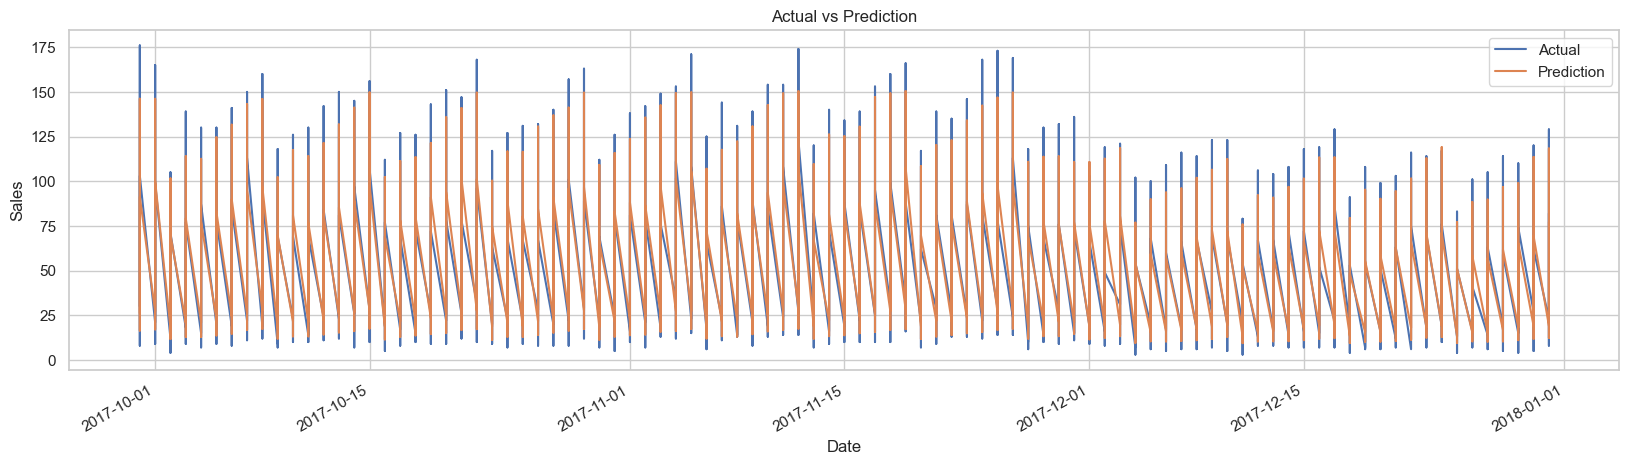

In [30]:
plot_predictions(X_test.index, np.expm1(y_test), np.expm1(y_pred))

Our LightGBM model is performing well! Apparently, it tends to make more significant errors when predicting higher sales values. This makes sense, as a rapid increase in sales can be challenging for the model to capture.

Observing some actual and predicted values.

In [31]:
actual_pred_df = compare_actual_predicted(np.expm1(y_test), np.expm1(y_pred))
actual_pred_df.sample(n=15, random_state=42)

,Actual,Predicted,Residual
date,,,
2017-10-15,77.0,69.50,7.50
2017-10-04,94.0,83.85,10.15
2017-10-02,87.0,90.70,3.70
2017-10-17,22.0,29.87,7.87
2017-11-25,90.0,82.26,7.74
2017-10-14,100.0,92.34,7.66
2017-12-13,17.0,19.37,2.37
2017-11-11,50.0,61.96,11.96
2017-11-28,56.0,47.58,8.42


Regression metrics

Mean Absolute Error (MAE): 6.0958
Mean Absolute Percentage Error (MAPE): 13.2804
Mean Squared Error (MSE): 63.5354
Root Mean Squared Error (RMSE): 7.9709
R-Squared (R2): 0.9222


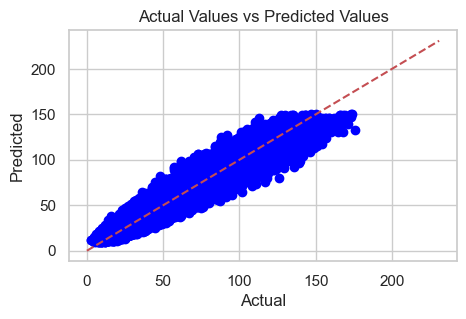

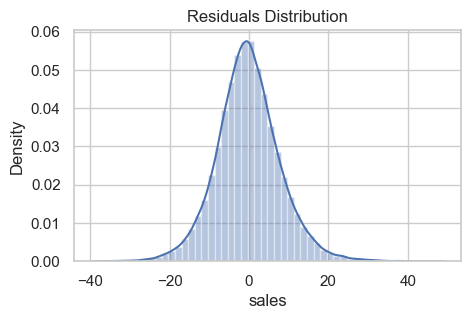

In [32]:
df_results = evaluate_regressor(np.expm1(y_test), np.expm1(y_pred), np.expm1(y_train), 'LightGBM')

In [33]:
df_results

,Model,MAE,MAPE,RMSE,R2
Results,LightGBM,6.0958,13.2804,7.9709,0.9222


Let's quickly compare test and train performances in order to prevent overfitting. Train, test and validation errors should be similar for a good fit.

In [34]:
y_pred_train = lgb_reg.predict(X_train)
print(f'Training RMSE = {round(np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))), 4)}')

Training RMSE = 7.6754


Train, test and validation errors are similar! Our model performs well with unseen data, presenting a good fit.

Our final lightgbm model presents a great performance!

1. <b>MAE</b> Our model's predictions, on average, are off by 6.1 units of the target variable (sales).
2. <b>RMSE</b> tells us explicitly how much our predictions deviate, on average, from the actual values in the dataset. In this case, our predicted values are around 7.97 units away from the actual value, which indicates a good generalization error and model performance, considering an average number sales of 52 products. RMSE is more conservative than MAE.
3. <b>R-squared (R2)</b> is a statistical metric used to measure the proportion of variance in the dependent variable explained by the independent variable(s). It ranges from 0 to 1, where 0 indicates the model does not explain any variance, and 1 indicates a perfect fit. R2 is commonly used to assess the goodness of fit of a regression model. According to the R-squared, 92% of the variance in the dependent variable is explained by the model. Very good!
4. <b>MAPE</b> A MAPE of 13.28% mean that, on average, our predictions are either 13.28% higher or 13.28% lower than the actual values.
5. The <b>residuals</b> seem to be normally distributed with mean zero and their variance is almost constant. These are some of the linear regression assumptions which helps us assess wheter our model is doing well.

### Feature importances
- I will look at feature importances, in order to interpret LightGBM outcomes, perform some feature selection and see if the model results improve or not. An important task when performing supervised learning on a dataset is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do.
- LightGBM calculates feature importances by using the "split" value, which represents the number of times a feature is used to split data across all trees, weighted by the number of samples in each split.

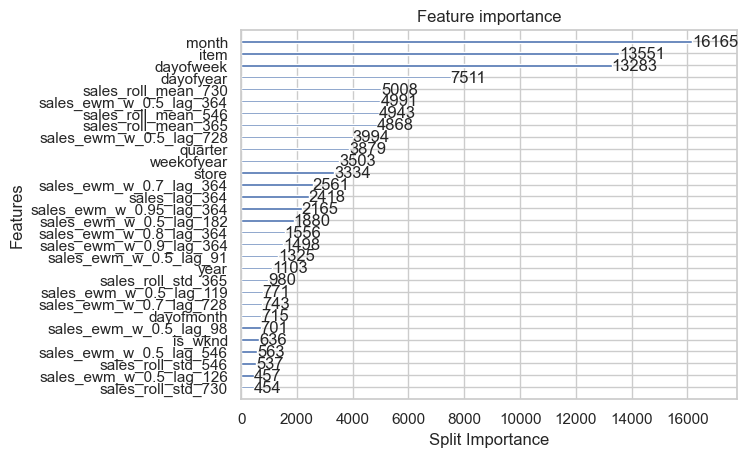

In [134]:
plot_importance(lgb_reg, max_num_features=30, importance_type='split', xlabel='Split Importance', ylabel='Features');

- Month, dayofweek and dayofyear are some of the most determinant features. This makes sense, since we have seasonality, with sales being higher in july and on sundays. 
- Rolling mean features and exponentially weighted mean features present a high predictive power!
- For the lag features, lag 364 was the only one between the 30 most important attributes.
- Some rolling standard deviation variables were also significantly important, like sales_roll_std_365

Let's select only those features with an importance higher than 700 and see wheter lightgbm's performance improve or not.

In [36]:
importances = lgb_reg.feature_importances_
SELECTION_THRESHOLD = 700
selected_features = [f for i, f in enumerate(X_train.columns) if importances[i] > SELECTION_THRESHOLD]
selected_features.append(TARGET)
print(f'Selected features: {selected_features}')

Selected features: ['store', 'item', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'sales_lag_364', 'sales_roll_mean_365', 'sales_roll_mean_546', 'sales_roll_mean_730', 'sales_roll_std_365', 'sales_ewm_w_0.95_lag_364', 'sales_ewm_w_0.9_lag_364', 'sales_ewm_w_0.8_lag_364', 'sales_ewm_w_0.7_lag_364', 'sales_ewm_w_0.7_lag_728', 'sales_ewm_w_0.5_lag_91', 'sales_ewm_w_0.5_lag_98', 'sales_ewm_w_0.5_lag_119', 'sales_ewm_w_0.5_lag_182', 'sales_ewm_w_0.5_lag_364', 'sales_ewm_w_0.5_lag_728', 'sales']


Performing feature selection and evaluating the model.

In [37]:
df_sel = df_prep[selected_features]
train_sel, test_sel = time_series_split(df_sel, CUTOFF_DATE)
X_train_sel = train_sel.drop(columns=[TARGET])
y_train_sel = train_sel[TARGET]
X_test_sel = test_sel.drop(columns=[TARGET])
y_test_sel = test_sel[TARGET]
X_train_sel.shape, y_train_sel.shape, X_test_sel.shape, y_test_sel.shape

((866500, 25), (866500,), (46500, 25), (46500,))

Training the model and making predictions.

In [38]:
lgb_sel = clone(lgb_reg)
lgb_sel.fit(X_train_sel, y_train_sel)
sel_pred = lgb_sel.predict(X_test_sel)

Mean Absolute Error (MAE): 6.0986
Mean Absolute Percentage Error (MAPE): 13.2825
Mean Squared Error (MSE): 63.6211
Root Mean Squared Error (RMSE): 7.9763
R-Squared (R2): 0.9221


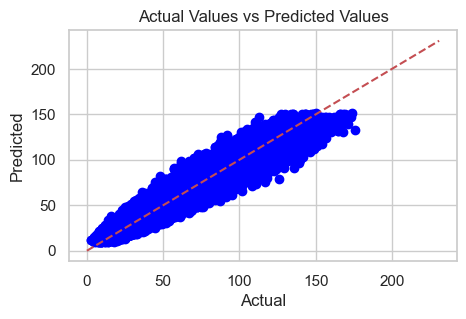

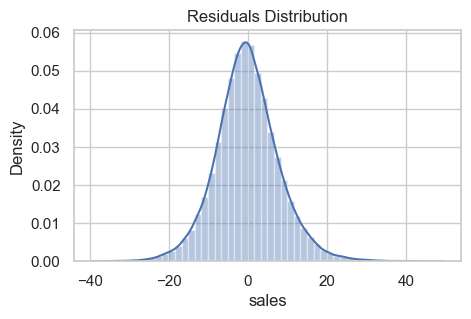

In [39]:
sel_results = evaluate_regressor(np.expm1(y_test_sel), np.expm1(sel_pred), np.expm1(y_train_sel), 'LightGBM')

Wow! By selecting only features with an importance higher than 700, it was possible to go from 78 to 25 features, turning the training and prediction steps faster without losing any performance! This occured because we have good data, and thus most of the time series features I added were not useful for the model. Considering this, I will stick with this feature selection model.

### Saving the models
I will save both the lightgbm models (with the entire data and after performing feature selection) in a pkl file for further deployment.

In [44]:
lgb_reg_path = os.path.join(os.pardir, 'models', 'lgb_reg.pkl')
lgb_sel_path = os.path.join(os.pardir, 'models', 'lgb_sel.pkl')
save_object(lgb_reg_path, lgb_reg)
save_object(lgb_sel_path, lgb_sel)

### Financial results
- The mean absolute error (MAE) tells us that our model's predictions, on average, are off by approximately 6.1 units of the target variable (sales). This is excellent, considering that the sales range from 0 to 231, with an average value of 52.25.
- Below I present the 3-month forecasted sales per store, per item and total sales, with the errors, worst scenarios (predicted value - mean absolute error) and best scenarios (predicted value + mean absolute error).

First, let's obtain the test set and rescale sales variable, once a log transformation was applied to it.

In [205]:
financial_results = test_sel.copy()
financial_results['sales'] = np.expm1(financial_results['sales'])
financial_results['predictions'] = np.expm1(sel_pred) 

Now let's apply the aggregations necessary to assess the business performances per store and item.

Per store.

In [290]:
sum_pred_stores = financial_results.groupby(['store'])['predictions'].sum().reset_index()
avg_pred_stores = financial_results.groupby(['store'])['predictions'].mean().reset_index()
mae_stores = financial_results.groupby(['store']).apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
sum_avg = pd.merge(sum_pred_stores, avg_pred_stores, how='inner', on='store').rename(columns={'predictions_x': 'total_predictions', 'predictions_y': 'average_predictions'})
stores_results = pd.merge(sum_avg, mae_stores, how='inner', on='store')
stores_results['worst_scenario_average'] = stores_results['average_predictions'] - stores_results['MAE']
stores_results['best_scenario_average'] = stores_results['average_predictions'] + stores_results['MAE']
stores_results['worst_scenario_total'] = stores_results['total_predictions'] - stores_results['MAE']
stores_results['best_scenario_total'] = stores_results['total_predictions'] + stores_results['MAE']
stores_results = stores_results.apply(lambda x: round(x, 2))
stores_results

,store,total_predictions,average_predictions,MAE,worst_scenario_average,best_scenario_average,worst_scenario_total,best_scenario_total
0,1,231857.88,49.86,5.71,44.15,55.57,231852.17,231863.59
1,2,326641.98,70.25,7.10,63.15,77.35,326634.88,326649.08
2,3,290908.56,62.56,6.54,56.02,69.10,290902.02,290915.10
3,4,269308.36,57.92,6.38,51.53,64.30,269301.98,269314.75
4,5,195426.74,42.03,5.31,36.71,47.34,195421.43,195432.06
5,6,194956.50,41.93,5.23,36.69,47.16,194951.27,194961.73
6,7,178273.44,38.34,4.96,33.38,43.30,178268.49,178278.40
7,8,313521.02,67.42,6.90,60.52,74.33,313514.11,313527.92
8,9,269951.94,58.05,6.43,51.62,64.49,269945.51,269958.38
9,10,287941.59,61.92,6.41,55.51,68.33,287935.18,287948.01


Interpretation: Store 2 will sell a total of 326,641.98 items in the next 3 months. On average, it will sell 70 items per day. Considering the error, these values can vary by 7 units. Thus, the best and worst scenarios (maximum and minimum that will be sold, error margin) for the total sales is 326649.08 and 326634.88 while for the average sales per day is 77.35 and 63.15.

Let's see the stores that will sell more and less products in the three-month period.

In [295]:
stores_results.sort_values(by=['total_predictions', 'average_predictions'], ascending=False).head(3).reset_index(drop=True)

,store,total_predictions,average_predictions,MAE,worst_scenario_average,best_scenario_average,worst_scenario_total,best_scenario_total
0,2,326641.98,70.25,7.10,63.15,77.35,326634.88,326649.08
1,8,313521.02,67.42,6.90,60.52,74.33,313514.11,313527.92
2,3,290908.56,62.56,6.54,56.02,69.10,290902.02,290915.10


In [306]:
stores_results.sort_values(by=['total_predictions', 'average_predictions'], ascending=True).head(3).reset_index(drop=True)

,store,total_predictions,average_predictions,MAE,worst_scenario_average,best_scenario_average,worst_scenario_total,best_scenario_total
0,7,178273.44,38.34,4.96,33.38,43.30,178268.49,178278.40
1,6,194956.50,41.93,5.23,36.69,47.16,194951.27,194961.73
2,5,195426.74,42.03,5.31,36.71,47.34,195421.43,195432.06


Stores 2, 3 and 8 will sell more items in the 3-month period while stores 7, 6 and 5 will sell less items.

Per store per item.

In [291]:
sum_pred_items = financial_results.groupby(['store', 'item'])['predictions'].sum().reset_index()
avg_pred_items = financial_results.groupby(['store', 'item'])['predictions'].mean().reset_index()
mae_items = financial_results.groupby(['store', 'item']).apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
sum_avg = pd.merge(sum_pred_items, avg_pred_items, how='inner', on=['store', 'item']).rename(columns={'predictions_x': 'total_predictions', 'predictions_y': 'average_predictions'})
items_results = pd.merge(sum_avg, mae_items, how='inner', on=['store', 'item'])
items_results['worst_scenario_average'] = items_results['average_predictions'] - items_results['MAE']
items_results['best_scenario_average'] = items_results['average_predictions'] + items_results['MAE']
items_results['worst_scenario_total'] = items_results['total_predictions'] - items_results['MAE']
items_results['best_scenario_total'] = items_results['total_predictions'] + items_results['MAE']
items_results = items_results.apply(lambda x: round(x, 2))
items_results


,store,item,total_predictions,average_predictions,MAE,worst_scenario_average,best_scenario_average,worst_scenario_total,best_scenario_total
0,1,1,1969.38,21.18,3.81,17.37,24.99,1965.57,1973.19
1,1,2,5198.82,55.90,6.46,49.44,62.36,5192.36,5205.28
2,1,3,3278.57,35.25,4.46,30.80,39.71,3274.11,3283.03
3,1,4,1954.92,21.02,3.33,17.69,24.35,1951.59,1958.25
4,1,5,1653.18,17.78,3.17,14.60,20.95,1650.00,1656.35
...,...,...,...,...,...,...,...,...,...
495,10,46,6510.43,70.00,7.68,62.33,77.68,6502.75,6518.11
496,10,47,2443.24,26.27,4.30,21.97,30.57,2438.93,2447.54
497,10,48,5705.11,61.35,6.39,54.96,67.73,5698.72,5711.50
498,10,49,3250.92,34.96,5.00,29.95,39.96,3245.91,3255.92


Interpretation: Store 1 will sell 5199 units of item 2 in the next 3 months. On average, it will sell 56 units of this item per day. Considering the error, these values can vary by 6 units. Thus, the best and worst scenarios for the total and average sales are 5205.28, 5192.36 and 62.36, 49.44.

Let's assess the most and less sold items and their stores.

In [297]:
items_results.sort_values(by=['total_predictions', 'average_predictions'], ascending=False).head(3).reset_index(drop=True)

,store,item,total_predictions,average_predictions,MAE,worst_scenario_average,best_scenario_average,worst_scenario_total,best_scenario_total
0,2,15,10735.68,115.44,8.92,106.52,124.36,10726.76,10744.60
1,2,28,10643.85,114.45,11.04,103.41,125.49,10632.81,10654.88
2,8,15,10402.48,111.85,9.53,102.32,121.39,10392.94,10412.01


In [307]:
items_results.sort_values(by=['total_predictions', 'average_predictions'], ascending=True).head(3).reset_index(drop=True)

,store,item,total_predictions,average_predictions,MAE,worst_scenario_average,best_scenario_average,worst_scenario_total,best_scenario_total
0,7,5,1246.15,13.40,3.12,10.28,16.51,1243.04,1249.27
1,6,5,1361.92,14.64,3.41,11.23,18.06,1358.51,1365.33
2,5,5,1372.64,14.76,2.92,11.84,17.68,1369.72,1375.57


The items 15 and 28 will be the most sold ones in the best stores, 2 and 8, while the item 5 will be the less sold one, in stores 5, 6 and 7. Particularly, the items 15 and 28 will be sold by almost 10 times more than item 5.

Total result.

In [310]:
sum_pred = stores_results['total_predictions'].sum()
avg_pred = stores_results['average_predictions'].sum()
worst_scenario_avg = stores_results['worst_scenario_average'].sum()
best_scenario_avg = stores_results['best_scenario_average'].sum()
worst_scenario_sum = stores_results['worst_scenario_total'].sum()
best_scenario_sum = stores_results['best_scenario_total'].sum()
total_result = pd.DataFrame({'total_prediction': sum_pred, 'average_prediction': avg_pred, 'worst_scenario_average': worst_scenario_avg, 'best_scenario_avg': best_scenario_avg, 'worst_scenario_sum': worst_scenario_sum, 'best_scenario_sum': best_scenario_sum}, index=[0]).apply(lambda x: round(x, 2))
total_result

,total_prediction,average_prediction,worst_scenario_average,best_scenario_avg,worst_scenario_sum,best_scenario_sum
0,2558788.01,550.28,489.28,611.27,2558727.04,2558849.02


The company will sell a total of 2,558,788.02 items in the next 3 months. 

### Conclusions
- In this project, I forecasted 3 months of sales for 50 items across 10 different stores of a company using LightGBM. Although it is a time series task, I resolved it using machine learning because this approach also shows very good results.
- The time dependency of the data was respected, doing a chronological train-test-split and an expanding window time series cross validation (to avoid using test set during modelling, simulating real production environment), separating 3 months for test and validation sets in order to simulate the reality of our problem.
- A quick analysis of the time series was made, breaking it into trend, seasonal, cyclical and residual components to assess information for the feature engineering. Then, a massive feature engineering was made, creating date-related features, lag features, rolling window features (mean and std), exponentially weighted mean features and a logarithmic transformation of the target. All of these data preparation approaches were tested using time series cross validation in order to assess wheter the feature addition was improving the model's performance.
- After the feature engineering, a bayesian optimization was applied using optuna. I did this just to refine a little bit my model, since the predictive power is contained on the features.
- Then, I evaluated the results and saw, with lightgbm feature importances, that many time series features created were not relevant. I dropped a lot of features based on an importance threshold, getting a reduced set without losing performance.
- The final lightgbm model showed great results. With a mean absolute error (MAE) of 6.1, our predictions, on average, are off by 6.1 units of the actual sales. This is excellent, considering an average sales of 52 and a range from 0 to 231.
- Then, I estimated financial results assessing the model's forecasting and the error to determine worst and best scenarios. I did this per store, per store and item, and for the total. The company will sell a total of 2,558,788.02 items in the next 3 months. 